In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from itertools import product

import gc
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

## 载入数据

In [2]:
path = './data/'
balance_user = pd.read_csv(path + 'user_balance_table.csv').sort_values(['user_id', 'report_date']).reset_index(drop=True)
balance_user['report_date'] = pd.to_datetime(balance_user['report_date'].astype(str))
balance_user.head()

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,2014-03-20,20111,0,20111,20111,0,20111,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,1,2014-03-21,20111,20111,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2,1,2014-03-22,20113,20111,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,2014-03-23,20115,20113,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,2014-03-24,20117,20115,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


In [3]:
train = balance_user.groupby('report_date')['total_purchase_amt', 'total_redeem_amt'].sum()
train.head()

,total_purchase_amt,total_redeem_amt
report_date,,
2013-07-01,32488348,5525022
2013-07-02,29037390,2554548
2013-07-03,27270770,5953867
2013-07-04,18321185,6410729
2013-07-05,11648749,2763587


In [39]:
train.index.to_series().resample('m').first().astype(str)

report_date
2013-07-31    2013-07-01
2013-08-31    2013-08-01
2013-09-30    2013-09-01
2013-10-31    2013-10-01
2013-11-30    2013-11-01
2013-12-31    2013-12-01
2014-01-31    2014-01-01
2014-02-28    2014-02-01
2014-03-31    2014-03-01
2014-04-30    2014-04-01
2014-05-31    2014-05-01
2014-06-30    2014-06-01
2014-07-31    2014-07-01
2014-08-31    2014-08-01
Freq: M, Name: report_date, dtype: object

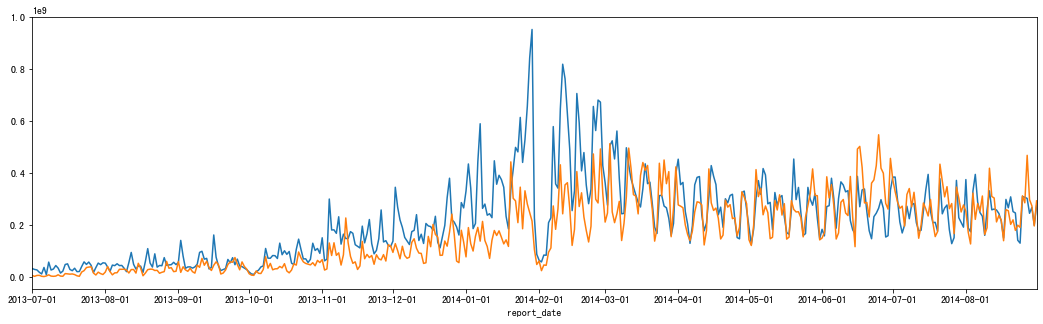

In [41]:
fig = plt.figure(figsize=(18, 5))
train['total_purchase_amt'].plot()
train['total_redeem_amt'].plot()
plt.xticks(list(train.index.to_series().resample('m').first()), 
           train.index.to_series().resample('m').first().astype(str));

In [44]:
train2 = train[train.index >= '20140301']
train2.head()

,total_purchase_amt,total_redeem_amt
report_date,,
2014-03-01,362865580,211279011
2014-03-02,276202230,246199417
2014-03-03,505305862,513017360
2014-03-04,524146340,250562978
2014-03-05,454295491,209072753


## 平稳性检验

In [4]:
# total_purchase_amt
adfuller(train['total_purchase_amt'])  # P值为0.4887，不能拒绝原假设

(-1.5898802926313507,
 0.4886749751375928,
 18,
 408,
 {'1%': -3.446479704252724,
  '5%': -2.8686500930967354,
  '10%': -2.5705574627547096},
 15960.28197033403)

In [5]:
# total_purchase_amt
adfuller(train['total_redeem_amt'])  # P值为0.5954，不能拒绝原假设

(-1.372413679828339,
 0.5954275877949474,
 13,
 413,
 {'1%': -3.4462831955497135,
  '5%': -2.8685636962704395,
  '10%': -2.5705114078759914},
 15816.780952766481)

### 一阶差分处理

In [6]:
train['purchase_1dif'] = train['total_purchase_amt'].diff(1)
train['redeem_1dif'] = train['total_redeem_amt'].diff(1)
train.head(3)

,total_purchase_amt,total_redeem_amt,purchase_1dif,redeem_1dif
report_date,,,,
2013-07-01,32488348,5525022,NaN,NaN
2013-07-02,29037390,2554548,-3450958.0,-2970474.0
2013-07-03,27270770,5953867,-1766620.0,3399319.0


In [7]:
# purchase_1dif
adfuller(train['purchase_1dif'].dropna())  # P值为3.1981e-12，远小于0.01，拒绝原假设，此时为平稳序列

(-7.947102224652343,
 3.198186862488185e-12,
 18,
 407,
 {'1%': -3.4465195891135845,
  '5%': -2.8686676281678634,
  '10%': -2.5705668101226085},
 15918.844657651942)

In [8]:
# redeem_1dif
adfuller(train['redeem_1dif'].dropna())  # P值为1.6443e-21，远小于0.01，拒绝原假设，此时为平稳序列

(-11.69198690696884,
 1.6443717458497645e-21,
 12,
 413,
 {'1%': -3.4462831955497135,
  '5%': -2.8685636962704395,
  '10%': -2.5705114078759914},
 15779.04993673871)

### ARIMA模型拟合与预测

In [48]:
def predict_with_arma(data, max_p, max_q, dif=1):
    best_aic = float('inf')
    for p, q in product(range(max_p+1), range(max_q+1)):
        print(f'\r当前拟合order = ({p}, {dif}, {q})', end='')
        try:
            alg = ARIMA(data, order=(p, dif, q)).fit()
            if alg.aic < best_aic:
                best_order = (p, dif, q)
                best_aic = alg.aic
                best_alg = alg
        except Exception:
            pass
    print(f'\rbest_order = {best_order}, 对应 AIC = {best_aic:.2f}.')
    return(best_alg.predict('2014-09-01', '2014-09-30', typ='levels'))

In [10]:
pre_purchase = predict_with_arma(train['total_purchase_amt'], max_p=8, max_q=8, dif=1)
pre_redeem = predict_with_arma(train['total_redeem_amt'], max_p=8, max_q=8, dif=1)

best_order = (8, 1, 4), 对应 AIC = 16653.32.
best_order = (8, 1, 7), 对应 AIC = 16468.78.


In [11]:
pre_res = pd.concat([pre_purchase, pre_redeem], axis=1)
pre_res.columns = ['purchase', 'redeem']
pre_res.index.name = 'date'
pre_res.head()

,purchase,redeem
date,,
2014-09-01,3.206019e+08,3.687988e+08
2014-09-02,3.290633e+08,3.188757e+08
2014-09-03,3.086676e+08,3.407753e+08
2014-09-04,2.562200e+08,3.291667e+08
2014-09-05,2.282802e+08,2.572588e+08


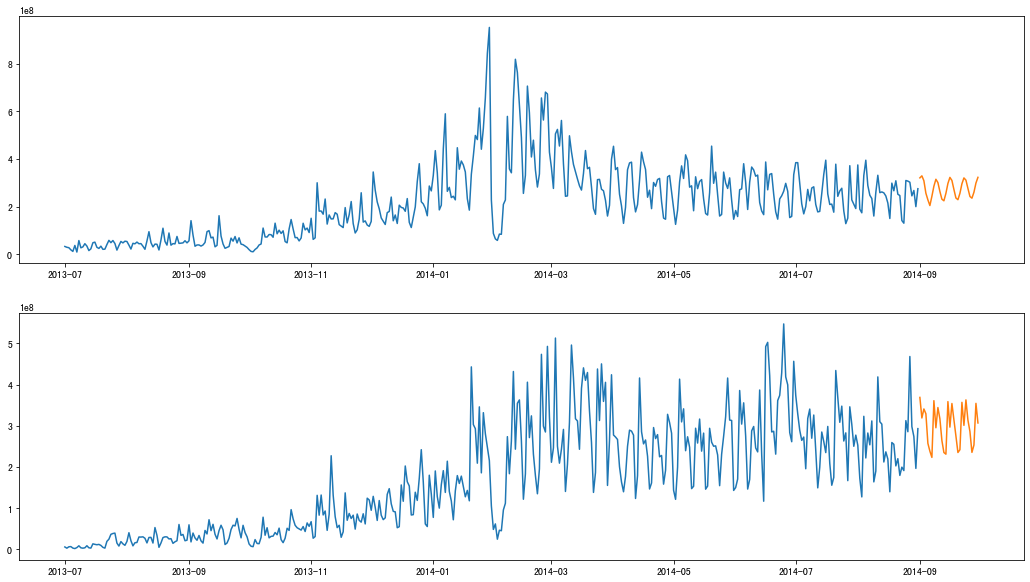

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(18, 10))
ax[0].plot(train['total_purchase_amt'])
ax[0].plot(pre_res['purchase'])
ax[1].plot(train['total_redeem_amt'])
ax[1].plot(pre_res['redeem'])

In [13]:
pre_res.reset_index(inplace=True)
pre_res['date'] = pre_res['date'].dt.strftime('%Y%m%d')
pre_res.head()

,date,purchase,redeem
0,20140901,3.206019e+08,3.687988e+08
1,20140902,3.290633e+08,3.188757e+08
2,20140903,3.086676e+08,3.407753e+08
3,20140904,2.562200e+08,3.291667e+08
4,20140905,2.282802e+08,2.572588e+08


In [14]:
pre_res.to_csv('./result/baseline_ARIMA.csv', header=None, index=None)

分数：105.2408
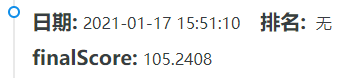

#### 使用train2

In [45]:
# total_purchase_amt
adfuller(train2['total_purchase_amt'])  # P值为0.0020，拒绝原假设,平稳

(-3.898615674902585,
 0.002045058630199904,
 13,
 170,
 {'1%': -3.469413468959902,
  '5%': -2.8786964197028295,
  '10%': -2.5759166089965397},
 6531.451592434938)

In [46]:
# total_purchase_amt
adfuller(train2['total_redeem_amt'])  # P值为0.1328，不能拒绝原假设

(-2.432317230236997,
 0.13282205070978398,
 14,
 169,
 {'1%': -3.469648263987657,
  '5%': -2.878798906308495,
  '10%': -2.5759713094779593},
 6609.942613022402)

In [47]:
train2['redeem_1dif'] = train['total_redeem_amt'].diff(1)
train2.head(3)

,total_purchase_amt,total_redeem_amt,redeem_1dif
report_date,,,
2014-03-01,362865580,211279011,-110751193.0
2014-03-02,276202230,246199417,34920406.0
2014-03-03,505305862,513017360,266817943.0


In [49]:
pre_purchase = predict_with_arma(train2['total_purchase_amt'], max_p=8, max_q=8, dif=0)
pre_redeem = predict_with_arma(train2['total_redeem_amt'], max_p=8, max_q=8, dif=1)

best_order = (6, 0, 5), 对应 AIC = 7125.26.
best_order = (4, 1, 5), 对应 AIC = 7154.98.


In [50]:
pre_res = pd.concat([pre_purchase, pre_redeem], axis=1)
pre_res.columns = ['purchase', 'redeem']
pre_res.index.name = 'date'
pre_res.head()

,purchase,redeem
date,,
2014-09-01,3.262348e+08,3.234942e+08
2014-09-02,3.393775e+08,3.357762e+08
2014-09-03,2.971387e+08,3.401884e+08
2014-09-04,2.771917e+08,3.334953e+08
2014-09-05,2.393579e+08,2.618630e+08


In [51]:
pre_res.reset_index(inplace=True)
pre_res['date'] = pre_res['date'].dt.strftime('%Y%m%d')
pre_res.head()

,date,purchase,redeem
0,20140901,3.262348e+08,3.234942e+08
1,20140902,3.393775e+08,3.357762e+08
2,20140903,2.971387e+08,3.401884e+08
3,20140904,2.771917e+08,3.334953e+08
4,20140905,2.393579e+08,2.618630e+08


In [52]:
pre_res.to_csv('./result/baseline_ARIMA_2.csv', header=None, index=None)

分数：101.4444